# DATA 607 Final Project: Garbage Classification

## Packages

In [38]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.models import load_model
from keras.utils import np_utils

from matplotlib import pyplot as plt

import shutil
import os
import imghdr
import numpy as np
import pandas as pd
import cv2
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [2]:
os.environ['KAGGLE_USERNAME'] = '---' # kaggle API username
os.environ['KAGGLE_KEY'] = '---' # kaggle API key
! kaggle datasets download -d mostafaabla/garbage-classification

garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
file_name = "/content/garbage-classification.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [4]:
import shutil
dir = "/content/garbage_classification/"
trash_list = ['trash', 'clothes', 'battery', 'shoes']
recyc_list = ['plastic', 'brown-glass', 'white-glass', 'cardboard', 'green-glass', 'metal', 'paper']
comp_list = ['biological']
for folder in os.listdir(dir):
  if folder in trash_list:
    dir_path = dir + 'trash/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in recyc_list:
    dir_path = dir + 'recyc/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in comp_list:
    dir_path = dir + 'comp/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)

for folder in os.listdir(dir):
  if folder not in ['trash', 'recyc', 'comp']:
    os.rmdir(dir + folder)

In [5]:
num_classes = len(list(os.listdir(dir)))
print(f'There are {num_classes} classes to classify')

There are 3 classes to classify


## Reading Images

In [6]:
images = []
labels = []
for img, label in tf.keras.utils.image_dataset_from_directory(directory='/content/garbage_classification', 
                                                              labels='inferred',
                                                              label_mode = 'int',
                                                              batch_size=None,
                                                              image_size=(16, 16)).take(-1).as_numpy_iterator():
  images.append(img)
  labels.append(label)

Found 15515 files belonging to 3 classes.


## Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

#Scaling RGB values to [0,1] range 
images = np.array(images)
images = images / 255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size = 0.8, random_state = 156, stratify= labels)

height, width, channels = (images.shape[1],images.shape[2],images.shape[3])

x_flat_train = x_train.reshape(x_train.shape[0], height * width * channels) 
x_flat_test = x_test.reshape(x_test.shape[0], height * width * channels)

del images, labels

In [8]:
import pickle
with open('x_train.pkl', 'wb') as file:
    pickle.dump(x_train, file)

with open('x_test.pkl', 'wb') as file:
    pickle.dump(x_test, file)

with open('y_train.pkl', 'wb') as file:
    pickle.dump(x_train, file)

with open('y_test.pkl', 'wb') as file:
    pickle.dump(x_test, file)

with open('x_flat_train.pkl', 'wb') as file:
    pickle.dump(x_train, file)

with open('x_flat_test.pkl', 'wb') as file:
    pickle.dump(x_test, file)

from google.colab import files
files.download('x_train.pkl')
files.download('x_test.pkl')
files.download('y_train.pkl')
files.download('y_test.pkl')
files.download('x_flat_train.pkl')
files.download('x_flat_test.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Classification Models

In [10]:
models_df = pd.DataFrame(columns = ['Model', 'Test_Accuracy'])

### Support Vector Machine (SVM)

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

params = {'C': [0.1, 1, 10], #Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
          'kernel': ['rbf', 'poly']} #Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).


svm = SVC()
grid_search = GridSearchCV(estimator = svm, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=  43.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=  54.9s
[CV] END ..................................C=0.1, kernel=rbf; total time=  46.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=  51.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=  43.4s
[CV] END .................................C=0.1, kernel=poly; total time=  38.3s
[CV] END .................................C=0.1, kernel=poly; total time=  41.9s
[CV] END .................................C=0.1, kernel=poly; total time=  40.6s
[CV] END .................................C=0.1, kernel=poly; total time=  35.8s
[CV] END .................................C=0.1, kernel=poly; total time=  36.8s
[CV] END ....................................C=1, kernel=rbf; total time=  38.1s
[CV] END ....................................C=1,

In [11]:
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['SMV', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.8195294875926523


In [12]:
models_df

,Model,Test_Accuracy
0,SMV,0.819529


In [13]:
import pickle
with open('SVM_Model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)

from google.colab import files
files.download('SVM_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### K-Nearest Neighbour (KNN) Classification

In [14]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': [3, 5, 7], #Number of neighbors to use by default for kneighbors queries.
          'weights': ['uniform', 'distance'], #‘uniform’ : uniform weights. All points in each neighborhood are weighted equally. ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
          'p': [1, 2]} #Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator = knn, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=  17.3s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=  17.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=  15.3s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=  17.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=  15.8s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=  15.1s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=  15.7s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=  15.4s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=  15.2s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=  15.0s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   2.0s
[CV] END ................n_neighbors=3, p=2, wei

In [15]:
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['KNN', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.7657106026426039


In [16]:
models_df

,Model,Test_Accuracy
0,SMV,0.819529
1,KNN,0.765711


In [17]:
import pickle
with open('KNN_Model.pkl', 'wb') as file:
    pickle.dump(best_knn, file)

from google.colab import files
files.download('KNN_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Gauissian Naive Bayes (GNB) Classifier

In [18]:
from sklearn.naive_bayes import GaussianNB

params = {'var_smoothing': np.linspace(0,0.5, num=50)}
gnb = GaussianNB()

grid_search = GridSearchCV(estimator = gnb, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................................var_smoothing=0.0; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.1s
[CV] END ..................var_smoothing=0.02040816326530612; total time=   0.1s
[CV] END ..................var_smoothing=0.0204

In [19]:
best_gnb = grid_search.best_estimator_
y_pred = best_gnb.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['GNB', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.5259426361585562


In [20]:
models_df

,Model,Test_Accuracy
0,SMV,0.819529
1,KNN,0.765711
2,GNB,0.525943


In [21]:
import pickle
with open('GNB_Model.pkl', 'wb') as file:
    pickle.dump(best_gnb, file)

from google.colab import files
files.download('GNB_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Random Forest (RFC) Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [50, 100, 200], #The number of trees in the forest.
          'max_depth': [None, 5, 10], #The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
          'min_samples_split': [2, 5, 10], #The minimum number of samples required to split an internal node:
          'min_samples_leaf': [1, 2, 4]} # The minimum number of samples required to be at a leaf node.

rfc = RandomForestClassifier(random_state=2019)

grid_search = GridSearchCV(estimator = rfc, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.9s
[CV] END max_dep

In [23]:
best_rfc = grid_search.best_estimator_
y_pred = best_rfc.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['RFC', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.8008378988076056


In [24]:
models_df

,Model,Test_Accuracy
0,SMV,0.819529
3,RFC,0.800838
1,KNN,0.765711
2,GNB,0.525943


In [25]:
import pickle
with open('RFC_Model.pkl', 'wb') as file:
    pickle.dump(best_rfc, file)

from google.colab import files
files.download('RFC_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### XGBoost (XGB) Classifier

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
from xgboost import XGBClassifier

params = {'n_estimators': [50, 100, 200],
          'max_depth': [3, 4, 5],
          'learning_rate': [0.1, 0.01, 0.001]}

xgb = XGBClassifier(random_state=2019, tree_method = 'gpu_hist')

grid_search = GridSearchCV(estimator = xgb, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(x_flat_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   2.7s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   1.6s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   1.6s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   2.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   2.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   2.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   4.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_e

In [34]:
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(x_flat_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['XGB', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.8369320012890751


In [35]:
models_df

,Model,Test_Accuracy
4,XGB,0.836932
0,SMV,0.819529
1,RFC,0.800838
2,KNN,0.765711
3,GNB,0.525943


In [36]:
import pickle
with open('XGB_Model.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)

from google.colab import files
files.download('XGB_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional Neueal Network (CNN) Classifier

In [41]:
np.random.seed(1337) 
inputs = Input(shape=(height, width, channels))

m = Conv2D(32, (3, 3), activation='relu')(inputs)
m = Conv2D(32, (3, 3), activation='relu')(m) 
m = MaxPooling2D(2, 2)(m)
m = Conv2D(64, (3, 3), activation='relu')(m)
m = Conv2D(64, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Flatten()(m)
m = Dense(128, activation='relu')(m)
m = Dense(128, activation='relu')(m)
fm = Dense(num_classes, activation='softmax')(m)

sub_model = Model(inputs=inputs, outputs=m)
cnn_model = Model(inputs=inputs, outputs=fm)

In [45]:
adam = Adam(lr=1e-4)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

cnn_model.compile(optimizer=adam,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

hist = cnn_model.fit(x_train, 
                     y_train, 
                     epochs=20, 
                     validation_split=0.2,
                     batch_size=64)

loss, accuracy = cnn_model.evaluate(x_test, 
                                    y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Epoch 1/20
156/156 [==============================] - 2s 7ms/step - loss: 0.4561 - accuracy: 0.8039 - val_loss: 0.4921 - val_accuracy: 0.7841
Epoch 2/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4496 - accuracy: 0.8075 - val_loss: 0.4796 - val_accuracy: 0.7910
Epoch 3/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4445 - accuracy: 0.8086 - val_loss: 0.4778 - val_accuracy: 0.7942
Epoch 4/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4364 - accuracy: 0.8108 - val_loss: 0.4726 - val_accuracy: 0.7966
Epoch 5/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4299 - accuracy: 0.8166 - val_loss: 0.4815 - val_accuracy: 0.7902
Epoch 6/20
156/156 [==============================] - 1s 4ms/step - loss: 0.4258 - accuracy: 0.8181 - val_loss: 0.4806 - val_accuracy: 0.7886
Epoch 7/20
156/156 [==============================] - 1s 4ms/step - loss: 0.4238 - accuracy: 0.8137 - val_loss: 0.4733 - val_accuracy: 0.7954
Epoch 

In [46]:
models_df = models_df.append(pd.Series(['CNN', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

In [47]:
models_df

,Model,Test_Accuracy
0,XGB,0.836932
1,SMV,0.819529
5,CNN,0.817596
2,RFC,0.800838
3,KNN,0.765711
4,GNB,0.525943


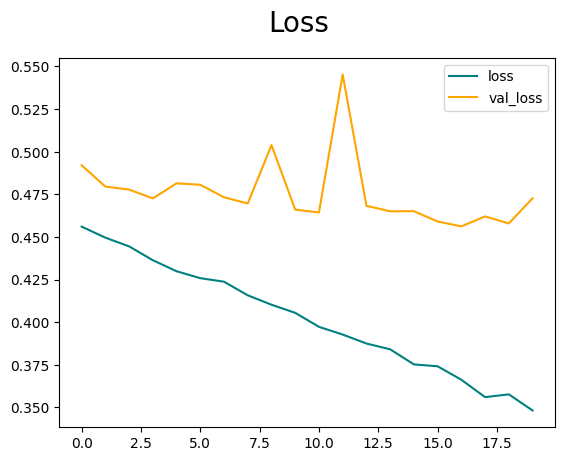

In [48]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

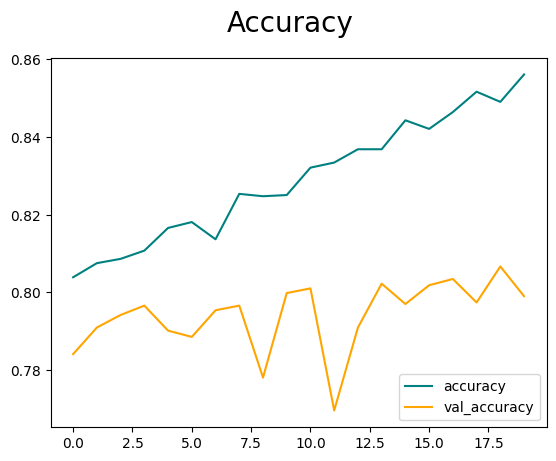

In [49]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [52]:
sub_model.save('/content/CNN_FinalDenseLayer.h5')
cnn_model.save('/content/CNN_Model.h5')

from google.colab import files
files.download('CNN_Model.h5')
files.download('CNN_FinalDenseLayer.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
train_file = sub_model.predict(x_train)
test_file = sub_model.predict(x_test)

z = np.concatenate([np.array(train_file).reshape(train_file.shape[0],train_file.shape[1]),np.array(y_train).reshape(train_file.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('train_file.csv',index=False)

z = np.concatenate([np.array(test_file).reshape(test_file.shape[0],test_file.shape[1]),np.array(y_test).reshape(test_file.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('test_file.csv',index=False)

97/97 [==============================] - 0s 2ms/step


In [54]:
files.download('train_file.csv')
files.download('test_file.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional SVM

In [55]:
params = {'C': [0.1, 1, 10],
          'kernel': ['rbf', 'poly']}

svm = SVC()
grid_search = GridSearchCV(estimator = svm, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.3s
[CV] END ..................................C=0.1, kernel=rbf; total time=   5.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=   5.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   3.8s
[CV] END .................................C=0.1, kernel=poly; total time=   4.3s
[CV] END .................................C=0.1, kernel=poly; total time=   3.4s
[CV] END .................................C=0.1, kernel=poly; total time=   3.3s
[CV] END .................................C=0.1, kernel=poly; total time=   3.9s
[CV] END .................................C=0.1, kernel=poly; total time=   3.5s
[CV] END ....................................C=1, kernel=rbf; total time=   4.4s
[CV] END ....................................C=1,

In [56]:
best_cnn_svm = grid_search.best_estimator_
y_pred = best_cnn_svm.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['Convolutional SMV', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.8266194005800838


In [57]:
models_df

,Model,Test_Accuracy
0,XGB,0.836932
6,Convolutional SMV,0.826619
1,SMV,0.819529
2,CNN,0.817596
3,RFC,0.800838
4,KNN,0.765711
5,GNB,0.525943


In [58]:
import pickle
with open('CNN_SVM_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_svm, file)

from google.colab import files
files.download('CNN_SVM_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional KNN

In [59]:
params = {'n_neighbors': [3, 5, 7],
          'weights': ['uniform', 'distance'], 
          'p': [1, 2]}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator = knn, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   2.6s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   4.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   2.6s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   2.5s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   2.5s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   2.5s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   3.9s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   2.5s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   2.5s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   2.5s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.3s
[CV] END ................n_neighbors=3, p=2, wei

In [60]:
best_cnn_knn = grid_search.best_estimator_
y_pred = best_cnn_knn.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['Convolutional KNN', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.8227521753142121


In [61]:
models_df

,Model,Test_Accuracy
0,XGB,0.836932
1,Convolutional SMV,0.826619
7,Convolutional KNN,0.822752
2,SMV,0.819529
3,CNN,0.817596
4,RFC,0.800838
5,KNN,0.765711
6,GNB,0.525943


In [62]:
import pickle
with open('CNN_KNN_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_knn, file)

from google.colab import files
files.download('CNN_KNN_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional GNB

In [63]:
params = {'var_smoothing': np.linspace(0,0.5, num=50)}
gnb = GaussianNB()

grid_search = GridSearchCV(estimator = gnb, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................................var_smoothing=0.0; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.01020408163265306; total time=   0.0s
[CV] END ..................var_smoothing=0.02040816326530612; total time=   0.0s
[CV] END ..................var_smoothing=0.0204

In [64]:
best_cnn_gnb = grid_search.best_estimator_
y_pred = best_cnn_gnb.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['Convolutional GNB', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.7834353851111827


In [65]:
models_df

,Model,Test_Accuracy
0,XGB,0.836932
1,Convolutional SMV,0.826619
2,Convolutional KNN,0.822752
3,SMV,0.819529
4,CNN,0.817596
5,RFC,0.800838
8,Convolutional GNB,0.783435
6,KNN,0.765711
7,GNB,0.525943


In [66]:
import pickle
with open('CNN_GNB_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_gnb, file)

from google.colab import files
files.download('CNN_GNB_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional RFC

In [67]:
params = {'n_estimators': [50, 100, 200],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]}

rfc = RandomForestClassifier(random_state=2019)

grid_search = GridSearchCV(estimator = rfc, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END max_dep

In [68]:
best_cnn_rfc = grid_search.best_estimator_
y_pred = best_cnn_rfc.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['Convolutional RFC', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.8275862068965517


In [69]:
models_df

,Model,Test_Accuracy
0,XGB,0.836932
9,Convolutional RFC,0.827586
1,Convolutional SMV,0.826619
2,Convolutional KNN,0.822752
3,SMV,0.819529
4,CNN,0.817596
5,RFC,0.800838
6,Convolutional GNB,0.783435
7,KNN,0.765711
8,GNB,0.525943


In [70]:
import pickle
with open('CNN_RFC_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_rfc, file)

from google.colab import files
files.download('CNN_RFC_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolutional XGB

In [71]:
from xgboost import XGBClassifier

params = {'n_estimators': [50, 100, 200],
          'max_depth': [3, 4, 5],
          'learning_rate': [0.1, 0.01, 0.001]}

xgb = XGBClassifier(random_state=2019, tree_method = 'gpu_hist')

grid_search = GridSearchCV(estimator = xgb, 
                           param_grid = params, 
                           cv=5,
                           scoring = 'accuracy',
                           verbose = 2)

grid_search.fit(train_file, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   3.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_e

In [72]:
best_cnn_xgb = grid_search.best_estimator_
y_pred = best_cnn_xgb.predict(test_file)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: ", accuracy)

models_df = models_df.append(pd.Series(['Convolutional XGB', accuracy], index=models_df.columns), ignore_index=True)
models_df = models_df.sort_values('Test_Accuracy', ascending=False)

Accuracy on Testing Set:  0.8256525942636158


In [73]:
models_df

,Model,Test_Accuracy
0,XGB,0.836932
1,Convolutional RFC,0.827586
2,Convolutional SMV,0.826619
10,Convolutional XGB,0.825653
3,Convolutional KNN,0.822752
4,SMV,0.819529
5,CNN,0.817596
6,RFC,0.800838
7,Convolutional GNB,0.783435
8,KNN,0.765711


In [74]:
import pickle
with open('CNN_XGB_Model.pkl', 'wb') as file:
    pickle.dump(best_cnn_xgb, file)

from google.colab import files
files.download('CNN_XGB_Model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Comparison

In [75]:
models_df.to_csv('Classifiers.csv', index = False)
files.download('Classifiers.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
import plotly.express as px

fig = px.bar(x = models_df.Model,
             y = models_df.Test_Accuracy,
             title = 'Comparing Multiclass Classifiers<br><sup>Based on Accuracy Scores calculated on Test Dataset</sup>',
             template = 'simple_white',
             labels = {'Model': 'Classification Model', 'Test_Accuracy': 'Test Accuracy Score'}
             )
fig.show()